In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [44]:
class FixedModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Value"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
        
    
    def create_fixed_model(self, h):
        #Creating AutoLSTM model and predicting with hyperparameter tuning by optuna backend. This is based upon the first training dataframe
        initial_dataset, *_ = TimeSeriesDataset.from_df(self.dfs[0])
        LSTMmodel = AutoLSTM(h = h, backend = "optuna")
        LSTMmodel.fit(dataset = initial_dataset)
        
        for i in range(len(self.dfs)):
            dataset, *_ = TimeSeriesDataset.from_df(self.dfs[i])
            y_hat = LSTMmodel.predict(dataset = dataset)
            start_date = datetime.strptime(self.dates[i], "%Y-%m-%d")
            horizon_dates = [start_date + timedelta(weeks=j) for j in range(1, h+1)]
        
            fc = pd.DataFrame(y_hat.ravel(), index = pd.to_datetime(horizon_dates))
            self.forecasts.append(fc)
    
    def create_graph(self):
        self.plotting_df.index = self.overall_df.index
        self.plotting_df["Real Data"] = self.overall_df[self.overall_df_value_col]
        
        for i in range(len(self.forecasts)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            
            self.plotting_df[f"{english_date} Model"] = self.forecasts[i][0]
        
        self.plotting_df.iplot(xTitle = "Date", yTitle = "Count", title = "Fixed Parameter LSTM Predictions")
    
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mape[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmse[i]}")
            
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                value = row[0]
                self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, value]
                
            
        

In [77]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [78]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
#updated_df.sort_values(by = "date", inplace = True)

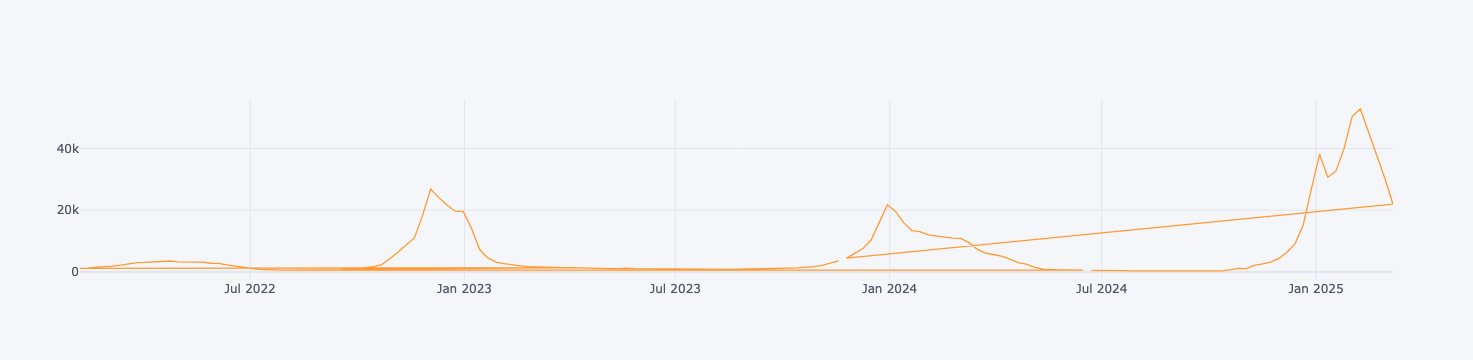

In [79]:
updated_df.iplot()

In [47]:
Processor = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [48]:
Processor.dates

['2024-10-05', '2024-10-19', '2024-11-02', '2024-11-16', '2024-12-07']

In [49]:
Processor.dfs

[]

In [50]:
Processor.create_training_dfs(value_col = "value")

In [51]:
Processor.dfs[0]

,y,ds,unique_id
date,,,
2022-02-05,1091.0,2022-02-05,series_1
2022-02-12,1164.0,2022-02-12,series_1
2022-02-19,1493.0,2022-02-19,series_1
2022-02-26,1603.0,2022-02-26,series_1
2022-03-05,1791.0,2022-03-05,series_1
...,...,...,...
2024-09-07,223.0,2024-09-07,series_1
2024-09-14,319.0,2024-09-14,series_1
2024-09-21,293.0,2024-09-21,series_1


In [52]:
Processor.create_fixed_model(4)

[I 2025-03-18 17:50:47,280] A new study created in memory with name: no-name-6850dade-e9e9-4af2-82b3-33e3bb3d98ab
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:50:51,980] Trial 0 finished with value: 1370.11181640625 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.09294384626351745, 'max_steps': 500, 'batch_size': 32, 'random_seed': 16, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 1370.11181640625.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:50:56,285] Trial 1 finished with value: 123.23179626464844 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.006260211637799508, 'max_steps': 500, 'batch_size': 32, 'random_seed': 7, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 123.23179626464844.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:51:04,224] Trial 2 finished with value: 50.64789962768555 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.005885320926230982, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16, 'input_size': 64, 'inference_input_size': -4}. Best is trial 2 with value: 50.64789962768555.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:51:15,736] Trial 3 finished with value: 72.6592025756836 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0004604293625757147, 'max_steps': 500, 'batch_size': 16, 'random_seed': 13, 'input_size': -4, 'inference_input_size': -4}. Best is trial 2 with value: 50.64789962768555.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:51:35,147] Trial 4 finished with value: 85.42493438720703 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.00018246859569284808, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 2, 'input_size': -4, 'inference_input_size': -4}. Best is trial 2 with value: 50.64789962768555.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:51:48,913] Trial 5 finished with value: 444.41650390625 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.034211784821928055, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16, 'input_size': 64, 'inference_input_size': -4}. Best is trial 2 with value: 50.64789962768555.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:51:54,666] Trial 6 finished with value: 67.45121765136719 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.021592203401925754, 'max_steps': 500, 'batch_size': 16, 'random_seed': 8, 'input_size': 256, 'inference_input_size': -4}. Best is trial 2 with value: 50.64789962768555.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:52:17,859] Trial 7 finished with value: 35.9753303527832 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.00039376856974690353, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 4, 'input_size': -4, 'inference_input_size': -4}. Best is trial 7 with value: 35.9753303527832.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:52:33,192] Trial 8 finished with value: 46.161720275878906 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0009255658451387623, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 3, 'input_size': 256, 'inference_input_size': -4}. Best is trial 7 with value: 35.9753303527832.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:52:37,746] Trial 9 finished with value: 626.2999877929688 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.014273378731820621, 'max_steps': 500, 'batch_size': 32, 'random_seed': 12, 'input_size': 16, 'inference_input_size': -4}. Best is trial 7 with value: 35.9753303527832.
[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 2.5 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [53]:
Processor.forecasts[1]

,0
2024-10-26,354.890747
2024-11-02,394.310547
2024-11-09,465.734497
2024-11-16,510.612732


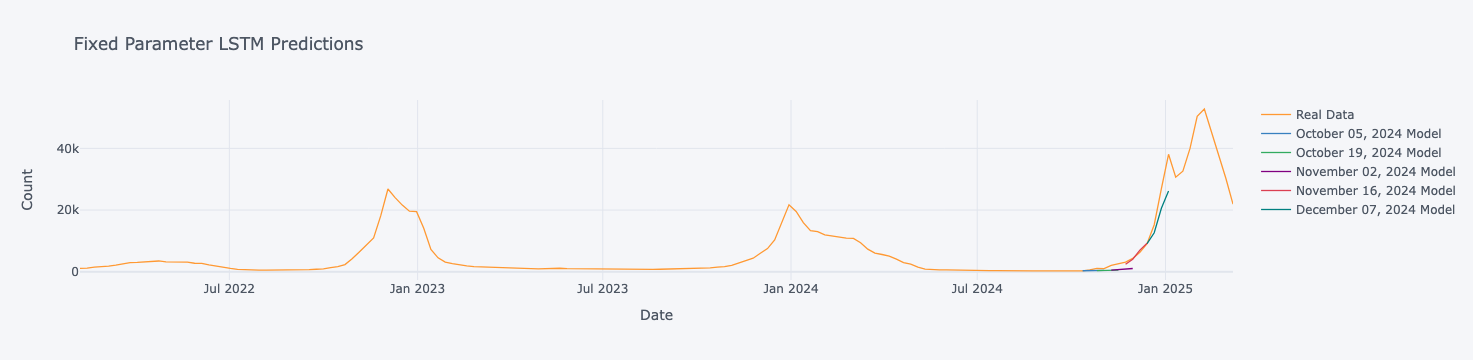

In [54]:
Processor.create_graph()

In [ ]:
Processor.plotting_df.iloc[-16:]

In [ ]:
Processor.forecasts[1]

In [ ]:
Processor.overall_df

In [ ]:
Processor.overall_df["value"].loc[Processor.forecasts[1].index]

In [55]:
Processor.calculate_metrics()

In [56]:
Processor.maes

[373.766357421875,
 1230.3628692626953,
 2233.4449310302734,
 429.71636962890625,
 5216.4111328125]

In [57]:
Processor.mses

[213397.69281405956,
 1867403.543606245,
 5401452.096293296,
 255711.0032761842,
 47195602.944540024]

In [58]:
Processor.mapes

[0.4157862271767067,
 0.7102411502866395,
 0.7448710806280036,
 0.09931747637263189,
 0.17983640530893408]

In [59]:
Processor.create_display_df()

In [60]:
Processor.display_df

,Reference Date,Target End Date,Value
0,2024-10-05,2024-10-12,307.249878
1,2024-10-05,2024-10-19,330.500854
2,2024-10-05,2024-10-26,384.070312
3,2024-10-05,2024-11-02,416.613281
4,2024-10-19,2024-10-26,354.890747
5,2024-10-19,2024-11-02,394.310547
6,2024-10-19,2024-11-09,465.734497
7,2024-10-19,2024-11-16,510.612732
8,2024-11-02,2024-11-09,524.849792
9,2024-11-02,2024-11-16,634.748108


In [61]:
class UpdatingModelProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Value"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_models(self, h):
        for i in range(len(self.dfs)):
            dataset, *_ = TimeSeriesDataset.from_df(self.dfs[i])
            LSTMmodel = AutoLSTM(h = h, backend = "optuna")
            LSTMmodel.fit(dataset = dataset)
            y_hat = LSTMmodel.predict(dataset = dataset)
            start_date = datetime.strptime(self.dates[i], "%Y-%m-%d")
            horizon_dates = [start_date + timedelta(weeks=j) for j in range(1, h+1)]
            
            fc = pd.DataFrame(y_hat.ravel(), index = pd.to_datetime(horizon_dates))
            self.forecasts.append(fc)
    
    def create_graph(self):
        self.plotting_df.index = self.overall_df.index
        self.plotting_df["Real Data"] = self.overall_df[self.overall_df_value_col]
        
        for i in range(len(self.forecasts)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            
            self.plotting_df[f"{english_date} Model"] = self.forecasts[i][0]
        
        self.plotting_df.iplot(xTitle = "Date", yTitle = "Count", title = "Updating Parameter LSTM Predictions")
    
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mape[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmse[i]}")
        
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                value = row[0]
                self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, value]
            
            

In [62]:
UpdatingProcessor = UpdatingModelProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [63]:
UpdatingProcessor.dates

['2024-10-05', '2024-10-19', '2024-11-02', '2024-11-16', '2024-12-07']

In [64]:
UpdatingProcessor.dfs

[]

In [65]:
UpdatingProcessor.create_training_dfs(value_col = "value")

In [66]:
UpdatingProcessor.dfs[2]

,y,ds,unique_id
date,,,
2022-02-05,1091.0,2022-02-05,series_1
2022-02-12,1164.0,2022-02-12,series_1
2022-02-19,1493.0,2022-02-19,series_1
2022-02-26,1603.0,2022-02-26,series_1
2022-03-05,1791.0,2022-03-05,series_1
...,...,...,...
2024-10-05,287.0,2024-10-05,series_1
2024-10-12,295.0,2024-10-12,series_1
2024-10-19,553.0,2024-10-19,series_1


In [67]:
UpdatingProcessor.create_models(4)

[I 2025-03-18 17:54:31,967] A new study created in memory with name: no-name-74da9e24-038a-43c5-b799-64f319573cdf
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 8.0 K  | train
5 | mlp_decoder     | MLP    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:54:37,868] Trial 0 finished with value: 889.9739990234375 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.03476375109876672, 'max_steps': 500, 'batch_size': 16, 'random_seed': 5, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 889.9739990234375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:54:51,580] Trial 1 finished with value: 129.59280395507812 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.0060242781188275816, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 9, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 129.59280395507812.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:54:59,726] Trial 2 finished with value: 261.33453369140625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.029750806662669264, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 13, 'input_size': 16, 'inference_input_size': -4}. Best is trial 1 with value: 129.59280395507812.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:55:09,027] Trial 3 finished with value: 31.934436798095703 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.001987663270437296, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 6, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:55:24,698] Trial 4 finished with value: 220.20700073242188 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.005154199271447121, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 11, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:55:33,537] Trial 5 finished with value: 121.5923080444336 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.007654289654899417, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16, 'input_size': 16, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:55:47,345] Trial 6 finished with value: 592.02294921875 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0001788246208226649, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 2, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:55:56,571] Trial 7 finished with value: 257.73919677734375 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0008795009456911139, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 2, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:56:08,142] Trial 8 finished with value: 40.79182052612305 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.001282525231933011, 'max_steps': 500, 'batch_size': 32, 'random_seed': 7, 'input_size': 256, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:56:12,554] Trial 9 finished with value: 207.76461791992188 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.001090940538806266, 'max_steps': 500, 'batch_size': 16, 'random_seed': 12, 'input_size': 16, 'inference_input_size': -4}. Best is trial 3 with value: 31.934436798095703.
[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 202 K  | train
4 | context_adapter | Linear        | 2.0 K  | train
5 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-18 17:56:21,726] A new study created in memory with name: no-name-f001ad17-59f6-455d-b894-01afe5a894ba
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 60.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:56:31,552] Trial 0 finished with value: 140.60581970214844 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0004217128996882419, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 140.60581970214844.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:56:43,171] Trial 1 finished with value: 107.18001556396484 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0001706517981063918, 'max_steps': 500, 'batch_size': 32, 'random_seed': 13, 'input_size': -4, 'inference_input_size': -4}. Best is trial 1 with value: 107.18001556396484.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:56:51,559] Trial 2 finished with value: 108.9330825805664 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.002620439833842807, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16, 'input_size': 256, 'inference_input_size': -4}. Best is trial 1 with value: 107.18001556396484.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:56:56,678] Trial 3 finished with value: 98.50495910644531 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.004462864103438256, 'max_steps': 500, 'batch_size': 32, 'random_seed': 15, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 98.50495910644531.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:57:04,862] Trial 4 finished with value: 447.20220947265625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.00018180615916877236, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 6, 'input_size': 16, 'inference_input_size': -4}. Best is trial 3 with value: 98.50495910644531.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:57:09,055] Trial 5 finished with value: 330.32061767578125 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0004414473067025259, 'max_steps': 500, 'batch_size': 32, 'random_seed': 9, 'input_size': 16, 'inference_input_size': -4}. Best is trial 3 with value: 98.50495910644531.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:57:12,992] Trial 6 finished with value: 115.58553314208984 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.013676784807133295, 'max_steps': 500, 'batch_size': 16, 'random_seed': 9, 'input_size': 256, 'inference_input_size': -4}. Best is trial 3 with value: 98.50495910644531.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:57:22,262] Trial 7 finished with value: 87.60933685302734 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.00035034462892826764, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 12, 'input_size': -4, 'inference_input_size': -4}. Best is trial 7 with value: 87.60933685302734.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:57:26,546] Trial 8 finished with value: 87.88433837890625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.005232836412481756, 'max_steps': 500, 'batch_size': 32, 'random_seed': 12, 'input_size': -4, 'inference_input_size': -4}. Best is trial 7 with value: 87.60933685302734.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:57:36,263] Trial 9 finished with value: 98.00717163085938 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.00025263866593342257, 'max_steps': 500, 'batch_size': 16, 'random_seed': 1, 'input_size': 256, 'inference_input_size': -4}. Best is trial 7 with value: 87.60933685302734.
[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 202 K  | train
4 | context_adapter | Linear        | 4.0 K  | train
5 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-18 17:57:45,457] A new study created in memory with name: no-name-2b9fe57b-5c30-4b33-bd9f-e8ab7dd37d0f
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:58:04,992] Trial 0 finished with value: 210.521484375 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0858473399941062, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:58:18,500] Trial 1 finished with value: 435.2422790527344 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.018257797948357905, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 6, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:58:26,787] Trial 2 finished with value: 350.16900634765625 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0002742532033817666, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 11, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:58:34,476] Trial 3 finished with value: 423.1835021972656 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.022680791142255446, 'max_steps': 500, 'batch_size': 32, 'random_seed': 17, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:58:50,371] Trial 5 finished with value: 285.510009765625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.013031881806813701, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 1, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:59:05,967] Trial 6 finished with value: 557.4314575195312 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.026281083466580958, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 19, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:59:14,664] Trial 7 finished with value: 544.0306396484375 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0008562713631470035, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:59:18,689] Trial 8 finished with value: 414.5337829589844 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.08199511712211828, 'max_steps': 500, 'batch_size': 16, 'random_seed': 11, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 17:59:24,041] Trial 9 finished with value: 232.6926727294922 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.004574125541603766, 'max_steps': 500, 'batch_size': 16, 'random_seed': 2, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 210.521484375.
[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-18 17:59:43,708] A new study created in memory with name: no-name-114e29f1-6c69-472b-b04d-38de788ffe74
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 2.5 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 17:59:59,291] Trial 0 finished with value: 839.6966552734375 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.002675592017262544, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 17, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 839.6966552734375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:00:07,885] Trial 1 finished with value: 800.9669189453125 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.01256138784837723, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 6, 'input_size': -4, 'inference_input_size': -4}. Best is trial 1 with value: 800.9669189453125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:00:12,258] Trial 2 finished with value: 808.4082641601562 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.030794932176306817, 'max_steps': 500, 'batch_size': 32, 'random_seed': 2, 'input_size': 16, 'inference_input_size': -4}. Best is trial 1 with value: 800.9669189453125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:00:20,131] Trial 3 finished with value: 482.0157775878906 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.00021278801415326536, 'max_steps': 500, 'batch_size': 32, 'random_seed': 2, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:00:43,695] Trial 4 finished with value: 1279.0997314453125 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.0008138411400136743, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 10, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:00:53,526] Trial 5 finished with value: 913.9142456054688 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.00807035791352749, 'max_steps': 500, 'batch_size': 32, 'random_seed': 13, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:00:58,298] Trial 6 finished with value: 581.7637329101562 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.00018555470078708192, 'max_steps': 500, 'batch_size': 32, 'random_seed': 5, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:01:06,692] Trial 8 finished with value: 857.2574462890625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.004907737036314284, 'max_steps': 500, 'batch_size': 32, 'random_seed': 19, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:01:16,645] Trial 9 finished with value: 785.5838012695312 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.03714135103278611, 'max_steps': 500, 'batch_size': 32, 'random_seed': 9, 'input_size': 256, 'inference_input_size': -4}. Best is trial 3 with value: 482.0157775878906.
[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 60.2 K | train
5 | mlp_decode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-18 18:01:24,596] A new study created in memory with name: no-name-aafd1596-2802-4d65-9368-c6bce84aa201
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:01:38,096] Trial 0 finished with value: 1492.93017578125 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.003618083641624397, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 20, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 1492.93017578125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:01:45,875] Trial 1 finished with value: 2601.4052734375 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.099894688067421, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 13, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 1492.93017578125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:01:49,825] Trial 2 finished with value: 3401.86181640625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.008793019072513265, 'max_steps': 500, 'batch_size': 16, 'random_seed': 1, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 1492.93017578125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-18 18:01:53,933] Trial 3 finished with value: 1347.9608154296875 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.01591648982379168, 'max_steps': 500, 'batch_size': 32, 'random_seed': 15, 'input_size': 16, 'inference_input_size': -4}. Best is trial 3 with value: 1347.9608154296875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:02:06,024] Trial 5 finished with value: 1569.825927734375 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.00758350279617583, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14, 'input_size': 256, 'inference_input_size': -4}. Best is trial 4 with value: 803.528076171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:02:14,723] Trial 6 finished with value: 6168.7314453125 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.00022945493849483727, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 6, 'input_size': 256, 'inference_input_size': -4}. Best is trial 4 with value: 803.528076171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:02:38,737] Trial 7 finished with value: 3308.40234375 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.047841292886017336, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 14, 'input_size': -4, 'inference_input_size': -4}. Best is trial 4 with value: 803.528076171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-18 18:02:48,602] Trial 8 finished with value: 4196.5546875 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0001645098206303946, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 18, 'input_size': -4, 'inference_input_size': -4}. Best is trial 4 with value: 803.528076171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [68]:
UpdatingProcessor.forecasts[1]

,0
2024-10-26,289.870361
2024-11-02,303.552979
2024-11-09,311.268799
2024-11-16,336.647583


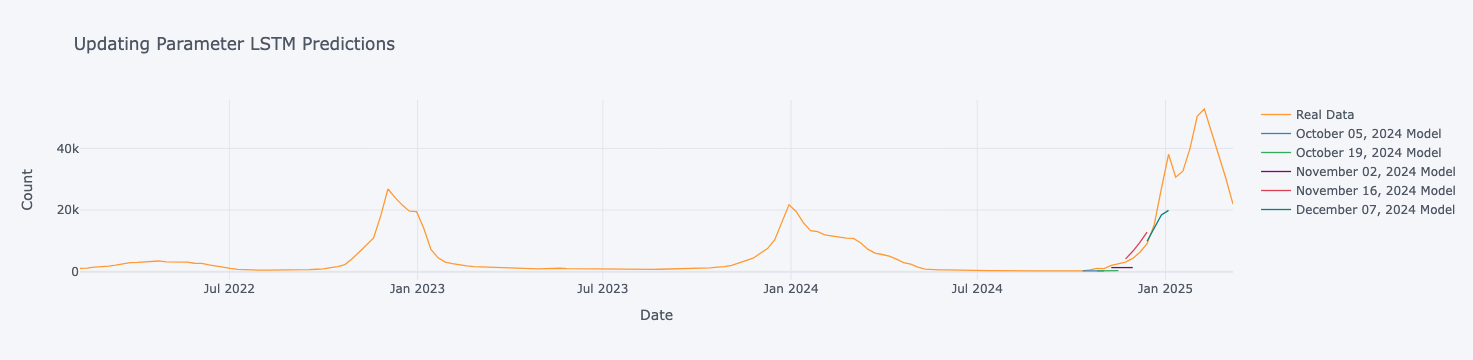

In [70]:
UpdatingProcessor.create_graph()

In [71]:
UpdatingProcessor.calculate_metrics()

In [72]:
UpdatingProcessor.maes

[440.26190185546875,
 1351.4150695800781,
 1662.349853515625,
 2576.873291015625,
 7156.382568359375]

In [73]:
UpdatingProcessor.create_display_df()

In [74]:
UpdatingProcessor.display_df

,Reference Date,Target End Date,Value
0,2024-10-05,2024-10-12,288.225708
1,2024-10-05,2024-10-19,281.444824
2,2024-10-05,2024-10-26,283.221802
3,2024-10-05,2024-11-02,295.060059
4,2024-10-19,2024-10-26,289.870361
5,2024-10-19,2024-11-02,303.552979
6,2024-10-19,2024-11-09,311.268799
7,2024-10-19,2024-11-16,336.647583
8,2024-11-02,2024-11-09,1331.650146
9,2024-11-02,2024-11-16,1331.650146
